In [1]:
import os
import json
import time
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
from sklearn.metrics import accuracy_score
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("run on cuda" if torch.cuda.is_available() else "CPU")

run on cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp -avr 'drive/My Drive/ProgettoCV204898/dataset.zip' ./
!cp -f 'drive/My Drive/ProgettoCV204898/testset_keys_1lug2020.txt' ./
!unzip -qq './dataset.zip' -d './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
'drive/My Drive/ProgettoCV204898/dataset.zip' -> './dataset.zip'


In [3]:
PATH='./'
DATASET_DIR = './dataset/'
DATASET_FILES = './dataset/examples/'
KEYSET_FILE = './testset_keys_1lug2020.txt'


LABELS = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" , 
          9: "walk" ,10: "discard"}


with open(os.path.join(DATASET_DIR, 'annotation_dict.json')) as fp:
    annotations = json.load(fp)

with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

len(annotations), len(annotationTrain), len(annotationTest)


(37085, 25959, 11126)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(list(annotationTrain.keys()), list(annotationTrain.values()), test_size=0.02, random_state=42)
X_test,y_test=list(annotationTest.keys()),list(annotationTest.values())


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
 
class S3D(nn.Module):
    def __init__(self, num_class):
        super(S3D, self).__init__()
        self.base = nn.Sequential(
            SepConv3d(3, 64, kernel_size=7, stride=2, padding=3),                           #Sep-Conv7x7x7
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),             #1x3x3 MaxPool
            BasicConv3d(64, 64, kernel_size=1, stride=1),                                   #1x1x1 Conv
            SepConv3d(64, 192, kernel_size=3, stride=1, padding=1),                         #Sep-Conv 3x3x3 (Conv3D 1x3x3->Conv3D 3x1x1)
            nn.MaxPool3d(kernel_size=(1,3,3), stride=(1,2,2), padding=(0,1,1)),             #1x3x3 MaxPool
            Mixed_3b(),
            Mixed_3c(),
            nn.MaxPool3d(kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            Mixed_4b(),
            Mixed_4c(),
            Mixed_4d(),
            Mixed_4e(),
            Mixed_4f(),
            nn.MaxPool3d(kernel_size=(2,2,2), stride=(2,2,2), padding=(0,0,0)),
            Mixed_5b(),
            Mixed_5c(),
        )
        self.fc = nn.Sequential(nn.Conv3d(1024, num_class, kernel_size=1, stride=1, bias=True),)
 
    def forward(self, x):
        y = self.base(x)
        y = F.avg_pool3d(y, (2, y.size(3), y.size(4)), stride=1)
        y = self.fc(y)
        y = y.view(y.size(0), y.size(1), y.size(2))
        logits = torch.mean(y, 2)
 
        return logits

In [6]:
class BasicConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv3d, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu = nn.ReLU()
 
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [7]:
class SepConv3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(SepConv3d, self).__init__()
        self.conv_s = nn.Conv3d(in_planes, out_planes, kernel_size=(1,kernel_size,kernel_size), stride=(1,stride,stride), padding=(0,padding,padding), bias=False)
        self.bn_s = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_s = nn.ReLU()
 
        self.conv_t = nn.Conv3d(out_planes, out_planes, kernel_size=(kernel_size,1,1), stride=(stride,1,1), padding=(padding,0,0), bias=False)
        self.bn_t = nn.BatchNorm3d(out_planes, eps=1e-3, momentum=0.001, affine=True)
        self.relu_t = nn.ReLU()
 
    def forward(self, x):
        x = self.conv_s(x)
        x = self.bn_s(x)
        x = self.relu_s(x)
 
        x = self.conv_t(x)
        x = self.bn_t(x)
        x = self.relu_t(x)
        return x

In [8]:
class Mixed_3b(nn.Module):
    def __init__(self):
        super(Mixed_3b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(192, 64, kernel_size=1, stride=1),                        #Branch 1x1x1
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(192, 96, kernel_size=1, stride=1),                        #Branch 1x1x1
            SepConv3d(96, 128, kernel_size=3, stride=1, padding=1),               #Conv3Dx3x3->Conv3D 3x1x1
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(192, 16, kernel_size=1, stride=1),                        #Branch 1x1x1
            SepConv3d(16, 32, kernel_size=3, stride=1, padding=1),                #Conv3Dx3x3->Conv3D 3x1x1
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),               #Branch MaxPool 3x3x3
            BasicConv3d(192, 32, kernel_size=1, stride=1),                        #Conv3D1x1x1
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)                                      #Concatenazione
 
        return out
 

In [9]:
class Mixed_3c(nn.Module):
    def __init__(self):
        super(Mixed_3c, self).__init__()
        self.branch0 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(256, 128, kernel_size=1, stride=1),
            SepConv3d(128, 192, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(256, 32, kernel_size=1, stride=1),
            SepConv3d(32, 96, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(256, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [10]:
class Mixed_4b(nn.Module):
    def __init__(self):
        super(Mixed_4b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(480, 192, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(480, 96, kernel_size=1, stride=1),
            SepConv3d(96, 208, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(480, 16, kernel_size=1, stride=1),
            SepConv3d(16, 48, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(480, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [11]:
class Mixed_4c(nn.Module):
    def __init__(self):
        super(Mixed_4c, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 160, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
            SepConv3d(112, 224, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [12]:
class Mixed_4d(nn.Module):
    def __init__(self):
        super(Mixed_4d, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 128, kernel_size=1, stride=1),
            SepConv3d(128, 256, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 24, kernel_size=1, stride=1),
            SepConv3d(24, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [13]:
class Mixed_4e(nn.Module):
    def __init__(self):
        super(Mixed_4e, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(512, 112, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(512, 144, kernel_size=1, stride=1),
            SepConv3d(144, 288, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(512, 32, kernel_size=1, stride=1),
            SepConv3d(32, 64, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(512, 64, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [14]:
class Mixed_4f(nn.Module):
    def __init__(self):
        super(Mixed_4f, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(528, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(528, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(528, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(528, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [15]:
class Mixed_5b(nn.Module):
    def __init__(self):
        super(Mixed_5b, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(832, 256, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 160, kernel_size=1, stride=1),
            SepConv3d(160, 320, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 32, kernel_size=1, stride=1),
            SepConv3d(32, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out
 

In [16]:
class Mixed_5c(nn.Module):
    def __init__(self):
        super(Mixed_5c, self).__init__()
 
        self.branch0 = nn.Sequential(
            BasicConv3d(832, 384, kernel_size=1, stride=1),
        )
        self.branch1 = nn.Sequential(
            BasicConv3d(832, 192, kernel_size=1, stride=1),
            SepConv3d(192, 384, kernel_size=3, stride=1, padding=1),
        )
        self.branch2 = nn.Sequential(
            BasicConv3d(832, 48, kernel_size=1, stride=1),
            SepConv3d(48, 128, kernel_size=3, stride=1, padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool3d(kernel_size=(3,3,3), stride=1, padding=1),
            BasicConv3d(832, 128, kernel_size=1, stride=1),
        )
 
    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out

In [17]:
from torchsummary import summary
summary(S3D(10).cuda(), (3,16, 176, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 16, 88, 64]           9,408
       BatchNorm3d-2       [-1, 64, 16, 88, 64]             128
              ReLU-3       [-1, 64, 16, 88, 64]               0
            Conv3d-4        [-1, 64, 8, 88, 64]          28,672
       BatchNorm3d-5        [-1, 64, 8, 88, 64]             128
              ReLU-6        [-1, 64, 8, 88, 64]               0
         SepConv3d-7        [-1, 64, 8, 88, 64]               0
         MaxPool3d-8        [-1, 64, 8, 44, 32]               0
            Conv3d-9        [-1, 64, 8, 44, 32]           4,096
      BatchNorm3d-10        [-1, 64, 8, 44, 32]             128
             ReLU-11        [-1, 64, 8, 44, 32]               0
      BasicConv3d-12        [-1, 64, 8, 44, 32]               0
           Conv3d-13       [-1, 192, 8, 44, 32]         110,592
      BatchNorm3d-14       [-1, 192, 8,

In [18]:
from PIL import Image
import torchvision.transforms as T
import albumentations
from skimage.io import imread
from skimage.transform import resize

def augmentation(aug,frame):
  frame=aug(image=np.array(frame))['image']
  return frame

class MyDataLoader(Dataset):
  def __init__(self,X,y,root_dir,par,transform=None):
    self.X=X
    self.y=y
    self.root_dir=root_dir
    self.transform=T.ToTensor()
    self.par=par
    if (par==1):
      self.aug = albumentations.Compose([
                albumentations.HorizontalFlip(p=0.5),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=15,
                    p=0.5
                ),
                albumentations.augmentations.transforms.RandomBrightnessContrast(p=0.5),
                albumentations.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
                
            ])
    else:
      self.aug = albumentations.Compose([
                albumentations.augmentations.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
                
            ])
    self.ok=[]
    self.okLab=[]
    return

  def __len__(self):
    return len(self.X)

  def getOk(self):
    return self.ok

  def getOkLab(self):
    return self.okLab
  
  def __getitem__(self,index):
    fname=self.root_dir+self.X[index]+".mp4"
    self.ok.append(self.X[index])
    self.okLab.append(self.y[index])
    video=cv2.VideoCapture(fname)
    image=[]
    r,g,b=[],[],[]
    while True:
      # Capture frame-by-frame
      ret , frame=video.read()
      if ret:
        frame= cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frame=augmentation(self.aug,frame)
        frame= self.transform(frame)
        r1 = frame[0]
        g1 = frame[1]
        b1 = frame[2]
        r1=r1.unsqueeze(0)
        g1=g1.unsqueeze(0)
        b1=b1.unsqueeze(0)
        r.append(r1)
        g.append(b1)
        b.append(b1)
      else:
        break
    r=torch.cat(r)
    g=torch.cat(g)
    b=torch.cat(b)
    image=torch.stack((r,g,b),dim=0)
    return image, self.y[index]
 


In [85]:
def train(epoch,steps,print_every,trainLoader,s):#
    train_loss=[]
    running_loss = 0
 
    for batch_idx, (inputs, labels) in enumerate(trainLoader): 
        inputs,labels= inputs.to(device), labels.to(device)
        logps = model(inputs)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if (batch_idx+1) % print_every == 0:
            s.append('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}' 
                   .format(epoch, epochs, batch_idx+1, steps, running_loss/(batch_idx*batch_size) ))
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}' 
                   .format(epoch, epochs, batch_idx+1, steps, running_loss/(batch_idx*batch_size)))
 
        train_loss.append(loss.item())
    return np.mean(train_loss)/len(trainLoader)

In [86]:
def val(model,valLoader,s,ret):
    val_loss = 0
    tp = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valLoader):
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model(inputs)
            ret+=logps
            _, predicted = torch.max(logps, 1)
            tp += (predicted == labels).sum().item()
            loss = criterion(logps,labels)
            val_loss += loss.item()
        val_loss /= len(valLoader.dataset)
        
        s.append('\nVal set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, tp, len(valLoader.dataset),
        100. * tp / len(valLoader.dataset)))
        print('\nVal set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, tp, len(valLoader.dataset),
        100. * tp / len(valLoader.dataset)))
        
    return val_loss,tp / len(valLoader.dataset)

In [87]:
def test(model,testLoader,criterion):
    test_loss = 0
    accuracy = 0
    test_losses=[]
    predictions=[]
    tp=[]
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testLoader):
            inputs, labels= inputs.to(device), labels.to(device)   
            tp+=labels
            logps = model(inputs)
            _, predicted = torch.max(logps, 1)
            predictions+=predicted
            accuracy += (predicted == labels).sum().item()
            loss = criterion(logps,labels)
            test_loss += loss.item()
            
        test_loss /= len(testLoader.dataset)
        test_losses.append(test_loss)
        
    return np.mean(test_losses),accuracy_score(np.array(tp).astype(int),np.array(predictions).astype(int))

In [88]:
def model():
  modello=S3D(10)
  modello.cuda()
  modello.to(device)
  return modello


def checkP(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,strings,out,name):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'criterion':criterion,
            'train_loss':train_loss,
            'val_loss':val_loss,
            'val_accs':val_accs,
            'strings':strings,
            'out':out
            }, PATH+name+".model")
  
def loadP(file):
  modello=model()
  checkpoint = torch.load(PATH+file+".model")
  optimizer = torch.optim.Adam(modello.parameters())
  modello.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  criterion = checkpoint['criterion']
  train_loss = checkpoint['train_loss']
  val_loss = checkpoint['val_loss']
  val_accs = checkpoint['val_accs']
  strings=checkpoint['strings']
  out=checkpoint['out']
  return modello,epoch,optimizer,criterion,train_loss,val_loss,val_accs,strings,out

In [89]:
def statVal(model,test_loader,criterion,val_accs):#
    print("Accuratezza sul validation",round(val_accs[-1]*100,2),"%")
    test_loss,test_accs=test(model,test_loader,criterion)
    print("La loss sul test vale ",round(test_loss,3))
    print("L'accuratezza del test vale", round(test_accs*100),"%")

def plotCompl(train_losses,val_losses,val_accs):
    plt.plot(range(len(train_losses)),train_losses, label='Training loss')
    plt.plot(range(len(val_losses)),val_losses, label='Validation loss')
    plt.plot(range(len(val_accs)),val_accs, label='Accuracy')
    plt.legend(frameon=False)
    plt.show();  

In [90]:
def start(learning_rate):
    modello,startEpoch,criterion=model(),1,nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(modello.parameters(), lr=learning_rate)
    return modello,startEpoch,optimizer,criterion

def restart(fname):
    model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=loadP(fname)
    print("Ok ripristino!")
    return model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output

def salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME):
     checkP(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,FNAME)
     print("salvato!")
    
        

In [91]:
def transferLearningModel():
  import os
  if not os.path.isfile('./s3d.model'):
    !wget -O './s3d.model' 'https://drive.google.com/uc?export=download&id=1HJVDBOQpnTMDVUM3SsXLy0HUkf_wryGO' 
  model = S3D(400)
  state_dict = torch.load("./s3d.model")
  # create new OrderedDict that does not contain `module.`
  from collections import OrderedDict
  new_state_dict = OrderedDict()
 
  for k, v in state_dict.items():
      name = k[7:] # remove `module.`
      new_state_dict[name] = v
 
  model.load_state_dict(new_state_dict)
  model = model.cuda()
  torch.backends.cudnn.benchmark = False
  # for param in model.parameters():
  #     param.requires_grad = False
 
  model.fc=nn.Sequential(
      nn.Conv3d(1024, 10, kernel_size=1, stride=1, bias=True))
 
  model_dict = model.state_dict()
 
  total_params = sum(p.numel() for p in model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
      p.numel() for p in model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')
 
  return model

In [ ]:
from sys import exit

RESTORE=True
FNAME="m12"
F2="m"
epochs=30
batch_size=32
learning_rate=0.0001
print_every=100
s=[]
output=[]
train_loss = []
val_loss = []
val_accs=[]


if not RESTORE:
    model,startEpoch,criterion=transferLearningModel(),1,nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)   
else:
    model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart(FNAME)
    optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) 

trainLoader= DataLoader(dataset=MyDataLoader(X_train,y_train,DATASET_FILES,1),batch_size=batch_size)
valLoader=DataLoader(dataset=MyDataLoader(X_val,y_val,DATASET_FILES,0),batch_size=batch_size)
model=model.to(device)
epoch=0

try:
    x=[]
    val(model,valLoader,s,x)
    step=len(trainLoader)
    output.append(x)
    for epoch in range(startEpoch,epochs):
            outx=[]
            sx=[]
            train_loss1=train(epoch,step,print_every,trainLoader,sx)
            val_loss1,val_accs1=val(model,valLoader,sx,outx)
            train_loss.append(train_loss1)
            val_loss.append(val_loss1)
            val_accs.append(val_accs1) 
            output.append(outx)
            s+=sx
    
except KeyboardInterrupt: 
    salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,F2+str(epoch))
    exit("Salavataggio modello all'epoca"+str(i))
    
    

salva(model,epoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output,F2)
  

In [92]:
model,startEpoch,optimizer,criterion,train_loss,val_loss,val_accs,s,output=restart('m12')
testLoader=DataLoader(dataset=MyDataLoader(X_test,y_test,DATASET_FILES,0),batch_size=batch_size)
statVal(model,testLoader,criterion,val_accs)


Ok ripristino!
Accuratezza sul validation 78.85 %
La loss sul test vale  0.018
L'accuratezza del test vale 80.0 %


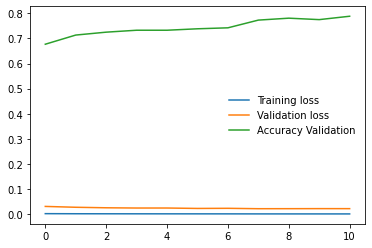

In [36]:
plotCompl(train_loss,val_loss,val_accs)